# Objectives
- Develop simple ABM for synthetic data generation
- Port code once completed to Python module


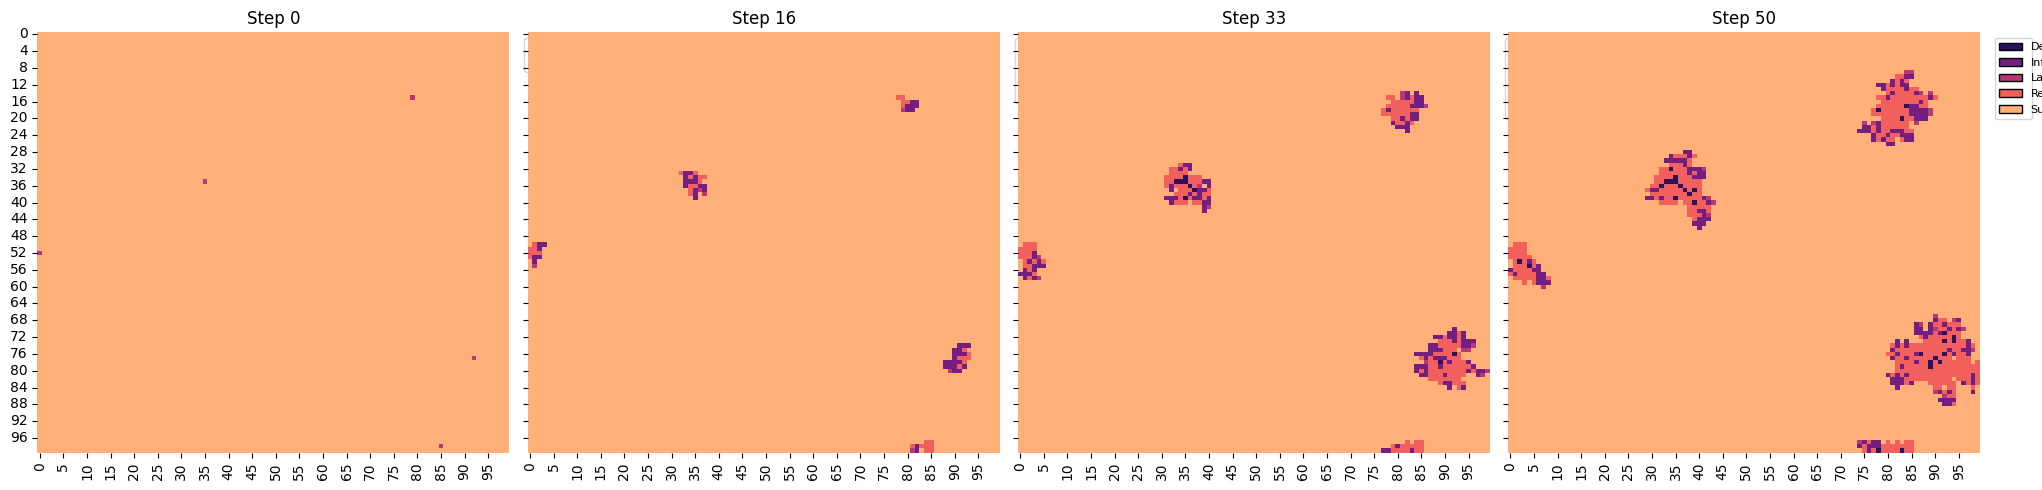

In [79]:
import numpy as np
import seaborn as sns
import catheat as ch

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

# Parameters
grid_size = (100, 100) 
infection_rate = 0.2
recovery_rate = 0.1
initial_infected = 5
simulation_steps = 50       # 50 days if dt = 24
dt = 24             # timestep in hours
mean_latency_period = 5*24      # hours

RECOVERED = 4       # treated with pesticide
SUSCEPTIBLE = 3     # no eggs or insects
LATENT = 2          # eggs present
INFECTED = 1        # insects present
DECEASED = 0        # deceased either by intentional culling or by disease

# track state and damage

# Initialize grid
field_state = np.full(grid_size, SUSCEPTIBLE)
damage = np.ones(grid_size)

latent_positions = np.random.choice(grid_size[0] * grid_size[1], initial_infected, replace=False)
for pos in latent_positions:
    field_state[pos // grid_size[1], pos % grid_size[1]] = LATENT

# Function to update the field (TODO: add treatment)
def update_field(field_state):
    damage_scale = 0.1*dt/24        # max damage per timestep (10 percent per day)
    p_infection = dt/mean_latency_period   # p_geometric = (mean timesteps until infection)^{-1}
    rng = np.random.default_rng()
    new_field = field_state.copy()
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if field_state[i, j] == INFECTED:
                damage[i,j] -= np.random.rand()*damage_scale
                if damage[i,j] > 0:
                    if np.random.rand() < recovery_rate:    # TODO: add treatment
                        new_field[i, j] = RECOVERED
                    else:
                        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            ni, nj = i + di, j + dj
                            if 0 <= ni < grid_size[0] and 0 <= nj < grid_size[1]:
                                if field_state[ni, nj] == SUSCEPTIBLE and np.random.rand() < infection_rate:
                                    new_field[ni, nj] = LATENT
                else:
                    new_field[i,j] = DECEASED
            elif field_state[i,j] == LATENT:
                if(rng.geometric(p_infection)):
                    new_field[i,j] = INFECTED

    # Apply treatment, override update
    return new_field

# Run simulation and collect history
history = [field_state.copy()]
for _ in range(simulation_steps):
    field_state = update_field(field_state)
    history.append(field_state.copy())

# Plot heatmap of infection density at various times
time_points = [0, simulation_steps // 3, 2 * simulation_steps // 3, simulation_steps]
fig, axes = plt.subplots(1, len(time_points), sharey=True, figsize=(20, 5))


# Define a mapping from integers to category strings
state_to_category = {
    RECOVERED: "Recovered",
    SUSCEPTIBLE: "Susceptible",
    LATENT: "Latent",
    INFECTED: "Infected",
    DECEASED: "Deceased"
}

# Create a copy of history with category strings
history_with_categories = [
    np.vectorize(state_to_category.get)(state_grid) for state_grid in history
]

magma_colors = sns.color_palette("magma",5)  # Extract 5 distinct colors for the states
cmap = {
    "Recovered": magma_colors[3],
    "Susceptible": magma_colors[4],
    "Latent": magma_colors[2],
    "Infected": magma_colors[1],
    "Deceased": magma_colors[0]
}

for idx, t in enumerate(time_points):
    ax = axes[idx]
    ch.heatmap(history_with_categories[t], palette= "magma", cmap=cmap, ax=ax)
    ax.set_title(f"Step {t}")
plt.tight_layout()
plt.show()